In [38]:
from pathlib import Path
import gzip
from functools import partial

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import (
    configure_plot_style,
    decode_weights,
    index_to_tnq,
    set_size,
    sharpe_ratio,
    solution_to_tnq,
    tnq_to_index,
    total_profit,
)

configure_plot_style()

PROJECT_ROOT = Path('..')
DATA_ROOT = PROJECT_ROOT / 'data' / 'portfolio' / 'instances'
RESULTS_ROOT = PROJECT_ROOT / 'results' / 'portfolio'
BENCHMARK_ROOT = PROJECT_ROOT / 'benchmark'

NS = 10
NT = 9
NQ = 2
K = 10

INSTANCE_ROOT = DATA_ROOT / f'po_a0{NS}_t{NT + 1}_orig'
INSTANCE_TAG = f'ising_Ns{NS}_Nt{NT}_Nq{NQ}_K{K}_gamma1_zeta0.042_rho1.0'

ARCHITECTURES = ('triangular', 'quadratic')
ARCHITECTURE_LABELS = {'triangular': 'Triangular', 'quadratic': 'Rectangular'}
ORDERINGS = ('fiedler', 'default', 'shuffle')
CHI_VALUES = [8, 16, 32, 64, 128]
RUNTIME_INSTANCES = range(10, 20)

SOLUTION_TO_TNQ = partial(solution_to_tnq, n_timesteps=NT, n_assets=NS, n_qubits=NQ)
INDEX_TO_TNQ = partial(index_to_tnq, NT, NS, NQ)
TNQ_TO_INDEX = partial(tnq_to_index, NT, NS, NQ)


def results_path(folder: str, architecture: str, chi: int, ordering: str, instance: int | None = None) -> Path:
    stem = f'{INSTANCE_TAG}_{architecture}_chi{chi}_{ordering}'
    base = RESULTS_ROOT / folder / stem
    return base / 'results.h5' if instance is None else base / f'ising_graph{instance}'


def dtau_path(architecture: str, chi: int, ordering: str) -> Path:
    return results_path('MPS_dtau10', architecture, chi, ordering)


def fix_dt_path(architecture: str, chi: int, ordering: str) -> Path:
    return results_path('MPS_fix_dt', architecture, chi, ordering)


# Dataset and helper utilities

In [39]:
def load_portfolio_inputs(root: Path):
    covariance_path = root / 'covariance_matrices.txt.gz'
    prices_path = root / 'stock_prices.txt.gz'

    cov_df = pd.read_csv(
        covariance_path,
        delim_whitespace=True,
        skiprows=9,
        header=None,
        names=['t', 'asset_i', 'asset_j', 'value'],
        compression='gzip',
    )
    prices_df = pd.read_csv(
        prices_path,
        delim_whitespace=True,
        skiprows=9,
        header=None,
        names=['t', 'asset', 'price'],
        compression='gzip',
    )

    asset_order = prices_df.loc[prices_df['t'] == 0, 'asset'].tolist()
    stock_to_index = {asset: idx for idx, asset in enumerate(asset_order)}

    prices = (
        prices_df
        .pivot(index='t', columns='asset', values='price')
        .loc[:, asset_order]
        .to_numpy()
    )

    sigma = np.zeros((NT, NS, NS))
    for _, row in cov_df.iterrows():
        t = int(row['t'])
        if t == 0:
            continue
        i = stock_to_index[row['asset_i']]
        j = stock_to_index[row['asset_j']]
        sigma[t - 1, i, j] = row['value']
        sigma[t - 1, j, i] = row['value']

    mu = np.log(prices[1:] / prices[:-1])

    return prices, mu, sigma, stock_to_index


prices, mu, sigma, STOCK_TO_INDEX = load_portfolio_inputs(INSTANCE_ROOT)
INDEX_TO_STOCK = {index: asset for asset, index in STOCK_TO_INDEX.items()}

/tmp/ipykernel_3061399/261242736.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cov_df = pd.read_csv(
/tmp/ipykernel_3061399/261242736.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prices_df = pd.read_csv(


In [40]:
pd.Series(STOCK_TO_INDEX, name='index').sort_values()

AAPL     0
NVDA     1
MSFT     2
GOOG     3
GOOGL    4
AMZN     5
META     6
TSLA     7
AVGO     8
WMT      9
Name: index, dtype: int64

Datasets `prices`, `mu`, and `sigma` are available for subsequent analysis.

Helper functions such as `decode_weights`, `total_profit`, and `sharpe_ratio` are provided by `utils.py`.

# Plots

## Ordering comparison

In [41]:
GUROBI_VALUE = -9.10104892705591
GUROBI_SOLUTION = np.array([
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
    1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
    0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
    0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
    0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
    1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0
], dtype=int)
GUROBI_TNQ = SOLUTION_TO_TNQ(GUROBI_SOLUTION)


/tmp/ipykernel_3061399/3671452065.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(CHI_VALUES)


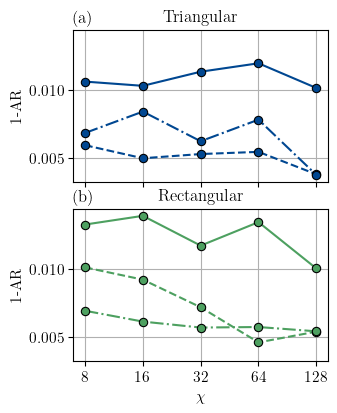

In [42]:
ORDERING_STYLES = {'fiedler': '--', 'default': '-.', 'shuffle': '-'}
ORDERING_LABELS = {'fiedler': 'Spectral', 'default': 'Hierarchical', 'shuffle': 'Shuffle'}

fig, axes = plt.subplots(len(ARCHITECTURES), 1, sharex=True, sharey=True)

for axis, architecture in zip(axes, ARCHITECTURES):
    gaps = {}
    for ordering in ORDERINGS:
        final_gap = []
        for chi in CHI_VALUES:
            path = dtau_path(architecture, chi, ordering)
            with h5py.File(path, 'r') as data:
                energy_samples = data['energy_samples'][:]
            best_energy = energy_samples.min()
            final_gap.append(1 - (best_energy / GUROBI_VALUE))
        gaps[ordering] = np.array(final_gap)
        axis.plot(
            gaps[ordering],
            linestyle=ORDERING_STYLES[ordering],
            color=f'C{ARCHITECTURES.index(architecture)}',
            marker='o',
            markersize=6,
            markeredgecolor='black',
            markeredgewidth=0.8,
            label=ORDERING_LABELS[ordering],
        )

    axis.grid(True)
    axis.set_title(f"({chr(ord('a') + ARCHITECTURES.index(architecture))})", loc='left')
    axis.set_title(f"{ARCHITECTURE_LABELS[architecture]}")
    axis.set_ylabel('1-AR')
    #axis.legend(loc='upper right')

axes[-1].set_xlabel(r"$\chi$")
axes[-1].set_xticklabels(CHI_VALUES)
axes[-1].set_xticks(range(len(CHI_VALUES)))

fig.set_size_inches(set_size(fraction=1, subplots=(len(ARCHITECTURES), 1)))
fig.set_dpi(100)
fig.tight_layout(pad=0.1)

fig.savefig('paper_figures/qubit_ordering_portfolio.pdf', bbox_inches='tight')


# Portfolio step diagnostics

## Error, profit, and Sharpe ratio over imaginary time

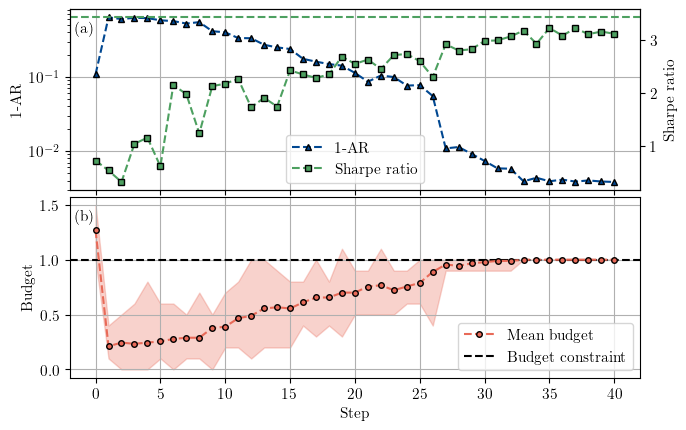

In [43]:
ANALYSIS_ARCHITECTURE = 'triangular'
ANALYSIS_ORDERING = 'fiedler'
ANALYSIS_CHI = 128
LAMBDA_COST = 0.042

with h5py.File(dtau_path(ANALYSIS_ARCHITECTURE, ANALYSIS_CHI, ANALYSIS_ORDERING), 'r') as data:
    samples = data['samples'][:]
    energy_samples = data['energy_samples'][:]

best_indices = energy_samples.argmin(axis=1)
best_samples = samples[np.arange(samples.shape[0]), best_indices]
tnq_solutions = np.array([SOLUTION_TO_TNQ(sample) for sample in best_samples])

best_energy = energy_samples.min(axis=1)
relative_error = 1 - (best_energy / GUROBI_VALUE)

sharpe_values = sharpe_ratio(tnq_solutions, mu, sigma, K)
sharpe_gurobi = sharpe_ratio(GUROBI_TNQ[None, ...], mu, sigma, K)[0]

net_profit = total_profit(tnq_solutions, mu, K, LAMBDA_COST)
net_profit_gurobi = total_profit(GUROBI_TNQ[None, ...], mu, K, LAMBDA_COST)[0]

budget_trajectories = decode_weights(tnq_solutions, K).sum(axis=2)
mean_budget = budget_trajectories.mean(axis=1)
min_budget = budget_trajectories.min(axis=1)
max_budget = budget_trajectories.max(axis=1)

fig, axes = plt.subplots(
    2,
    1,
    figsize=set_size(width='full', fraction=1, subplots=(2, 1), squeeze_height=0.5),
    sharex=True,
)

axes[0].semilogy(relative_error, marker='^', linestyle='--', markeredgecolor='black', markersize=4, label='1-AR')
axes[0].set_ylabel('1-AR')
axes[0].grid(True)
axes[0].text(0.01, 0.85, '(a)', transform=axes[0].transAxes, va='bottom', ha='left', fontweight='bold')

ax_sharpe = axes[0].twinx()
ax_sharpe.plot(sharpe_values, marker='s', linestyle='--', color='C1', markeredgecolor='black', markersize=4, label='Sharpe ratio')
ax_sharpe.axhline(sharpe_gurobi, color='C1', linestyle='--')
ax_sharpe.set_ylabel('Sharpe ratio')
ax_sharpe.set_xlabel('Step')

lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = ax_sharpe.get_legend_handles_labels()
axes[0].legend(lines + lines2, labels + labels2, loc='lower center')

axes[1].plot(mean_budget, label='Mean budget', color='C2', marker='o', linestyle='--', markeredgecolor='black', markersize=4, zorder=3)
axes[1].fill_between(np.arange(len(mean_budget)), min_budget, max_budget, color='C2', alpha=0.3)
axes[1].axhline(1, color='black', linestyle='--', label='Budget constraint')
axes[1].set_ylabel('Budget')
axes[1].set_xlabel('Step')
axes[1].grid(True)
axes[1].legend(loc='lower right')
axes[1].text(0.01, 0.85, '(b)', transform=axes[1].transAxes, va='bottom', ha='left', fontweight='bold')

fig.tight_layout(pad=0.1)
fig.savefig('./paper_figures/portfolio_optimization_results.pdf', dpi=300, bbox_inches='tight')

## Entanglement entropy over imaginary time

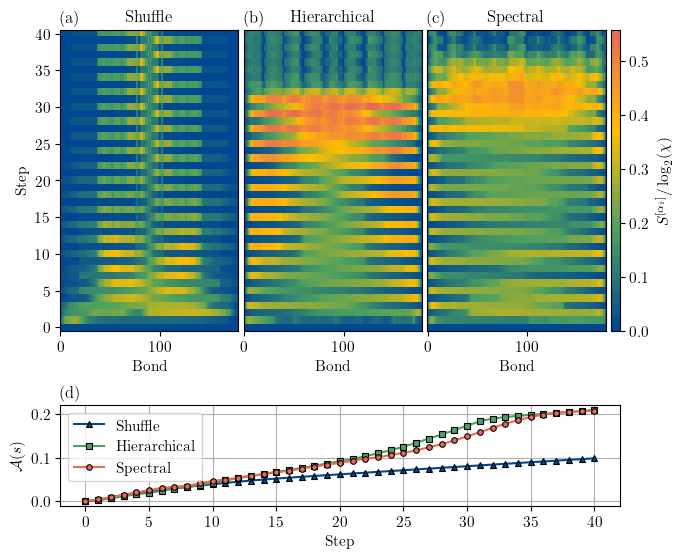

In [44]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

ENT_CHI = 128
ENT_ARCHITECTURE = 'triangular'
ENT_ORDERINGS = ('shuffle', 'default', 'fiedler')
ENT_LABELS = {'shuffle': 'Shuffle', 'default': 'Hierarchical', 'fiedler': 'Spectral'}

custom_cycle = ['#004791', '#4DA060', '#FFBE00', '#E86A58']
custom_cmap = LinearSegmentedColormap.from_list('portfolio_theme', colors=custom_cycle)

fig = plt.figure()
layout = gridspec.GridSpec(2, 4, height_ratios=[3, 1], width_ratios=[1, 1, 1, 0.05])
axes = [fig.add_subplot(layout[0, i]) for i in range(3)]
color_axis = fig.add_subplot(layout[0, 3])
ax_bottom = fig.add_subplot(layout[1, :])

vmax = -1
# Find global vmax for correct color scaling
for ordering, axis in zip(ENT_ORDERINGS, axes):
    with h5py.File(dtau_path(ENT_ARCHITECTURE, ENT_CHI, ordering), 'r') as data:
        # Print path
        entropy_raw = data['entanglement_entropy'][:]
        entropy_normalised = entropy_raw / np.log2(ENT_CHI)
        vmax = max(vmax, entropy_normalised.max())

entropy_data = {}
for ordering, axis in zip(ENT_ORDERINGS, axes):
    with h5py.File(dtau_path(ENT_ARCHITECTURE, ENT_CHI, ordering), 'r') as data:
        # Print path
        entropy_raw = data['entanglement_entropy'][:]
        entropy_normalised = entropy_raw / np.log2(ENT_CHI)

    entropy_data[ordering] = (entropy_normalised, entropy_raw)
    axis.imshow(entropy_normalised.T, aspect='auto', origin='lower', cmap=custom_cmap, vmin=0, vmax=vmax)
    axis.set_title(f"({chr(ord('a') + ENT_ORDERINGS.index(ordering))})", loc='left')
    axis.set_title(f"{ENT_LABELS[ordering]}")
    axis.set_xlabel('Bond')
    if axis is axes[0]:
        axis.set_ylabel('Step')
    else:
        axis.set_yticks([])

colorbar = fig.colorbar(axes[-1].images[0], cax=color_axis)
colorbar.set_label(r"$S^{[\alpha_i]}/\log_2(\chi)$")

for ordering, marker, color in zip(ENT_ORDERINGS, ['^', 's', 'o'], ['C0', 'C1', 'C2']):
    entropy_normalised, entropy_raw = entropy_data[ordering]
    cumulative = np.cumsum(entropy_raw.sum(axis=0)) / (179 * np.log2(ENT_CHI) * 40)
    ax_bottom.plot(
        cumulative,
        label=ENT_LABELS[ordering],
        linestyle='-',
        marker=marker,
        markeredgecolor='black',
        markersize=4,
        markeredgewidth=0.8,
        color=color,
    )

ax_bottom.grid(True)
ax_bottom.set_xlabel('Step')
ax_bottom.set_ylabel(r"$\mathcal{A}(s)$")
ax_bottom.legend()
ax_bottom.set_title('(d)', loc='left')

fig.tight_layout(pad=0.1)
fig.set_size_inches(set_size(width='full', fraction=1, squeeze_height=2, subplots=(2, 3)))
fig.savefig('./paper_figures/combined_plot.pdf', bbox_inches='tight')
